Takes an AOI and enumerates pairs of SLCs for interferograms.

In [7]:
import geopandas as gpd
import yaml
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import asf_search as asf
from datetime import timedelta
import datetime
from dateparser import parse
import concurrent.futures
import hyp3_sdk
import numpy as np
from data_model import enumParams

# Setup

In [8]:
YAML_FILE = 'enumeration_parameters.yml'
PARAMS = enumParams.from_yaml(YAML_FILE)

In [9]:
PARAMS.__dict__

{'temporal_baseline_days': [0, 90, 180, 365],
 'n_secondaries_per_reference': [4, 2, 2, 2],
 'aoi_name': 'tibet',
 'n_seeds': 2,
 'track_numbers': [136, 33],
 'data_directory': PosixPath('out'),
 'date_of_enum': datetime.date(2024, 2, 7),
 'stack_dir': PosixPath('out/tibet__tb_0-90-180-365__neigh_4-2-2-2/stack'),
 'enum_dir': PosixPath('out/tibet__tb_0-90-180-365__neigh_4-2-2-2/enum'),
 'yaml_path': PosixPath('out/tibet__tb_0-90-180-365__neigh_4-2-2-2/enum_params_2024-02-07.yml'),
 'weather_model': None,
 'month_constraint': None,
 'exclusive_month_constraints': False,
 'aoi_geojson_path': PosixPath('AOIs/tibet.geojson'),
 'valid_date_ranges': [(datetime.datetime(2014, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
   datetime.datetime(2022, 11, 1, 0, 0, tzinfo=datetime.timezone.utc))],
 'enum_parent_dir': PosixPath('out/tibet__tb_0-90-180-365__neigh_4-2-2-2')}

# Read enumeration data

In [10]:
list(PARAMS.enum_dir.glob('*.geojson'))

[PosixPath('out/tibet__tb_0-90-180-365__neigh_4-2-2-2/enum/track33-tibet.geojson'),
 PosixPath('out/tibet__tb_0-90-180-365__neigh_4-2-2-2/enum/track136-tibet.geojson')]

In [11]:
dfs = [gpd.read_file(p) for p in tqdm(list(PARAMS.enum_dir.glob('*.geojson')))]
df_ifg = pd.concat(dfs, axis=0)
df_ifg.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]


,reference,secondary,reference_date,secondary_date,frame_id,track_aoi_key,aoi_name,geometry
0,S1A_IW_SLC__1SDV_20221025T231816_20221025T2318...,S1A_IW_SLC__1SDV_20221013T231816_20221013T2318...,2022-10-25,2022-10-13,5033,track33,tibet,"POLYGON Z ((100.25651 40.66807 0.00000, 100.49..."
1,S1A_IW_SLC__1SDV_20221025T231844_20221025T2319...,S1A_IW_SLC__1SDV_20221013T231844_20221013T2319...,2022-10-25,2022-10-13,5034,track33,tibet,"POLYGON Z ((100.01676 39.50849 0.00000, 100.22..."
2,S1A_IW_SLC__1SDV_20221025T231910_20221025T2319...,S1A_IW_SLC__1SDV_20221013T231910_20221013T2319...,2022-10-25,2022-10-13,5035,track33,tibet,"POLYGON Z ((99.77975 38.34848 0.00000, 99.9506..."
3,S1A_IW_SLC__1SDV_20221025T231910_20221025T2319...,S1A_IW_SLC__1SDV_20221013T231910_20221013T2319...,2022-10-25,2022-10-13,5036,track33,tibet,"POLYGON Z ((99.54475 37.18812 0.00000, 99.6462..."
4,S1A_IW_SLC__1SDV_20221025T231935_20221025T2320...,S1A_IW_SLC__1SDV_20221013T231934_20221013T2320...,2022-10-25,2022-10-13,5037,track33,tibet,"POLYGON Z ((99.31155 36.02742 0.00000, 99.3450..."


In [12]:
df_ifg.shape

(19444, 8)

Let's look at each group and its size (i.e. the number of IFGs)

In [13]:
df_count = df_ifg.groupby('track_aoi_key').count().reset_index(drop=False)
df_count['track'] = df_count['track_aoi_key'].map(lambda key: int(key.replace('track', '')))
df_count.sort_values(by='track', inplace=True)
df_count

,track_aoi_key,reference,secondary,reference_date,secondary_date,frame_id,aoi_name,geometry,track
1,track33,11704,11704,11704,11704,11704,11704,11704,33
0,track136,7740,7740,7740,7740,7740,7740,7740,136


In [14]:
for k, row in df_count.iterrows():
    print(row['reference'])

11704
7740


# Filtering Jobs (Optional)

When first submitting jobs, you may just want to submit one track at a time. Easiest to filter on the dataframe with all the IFGs. That's what we will do. Below shows how to filter on a single "track_aoi_id".

In [15]:
df_ifg_submission = df_ifg.copy()

Can uncomment and figure out which track aois to use

In [19]:
# df_ifg_submission = df_ifg[df_ifg.track_aoi_key != 'track106'].reset_index(drop=True)
# df_ifg_submission.head()

In [20]:
from s1_frame_enumerator import get_global_gunw_footprints
import matplotlib.pyplot as plt
import contextily as cx

df_gunw_foot = get_global_gunw_footprints()

In [21]:
frames_enum = df_ifg_submission.frame_id.unique().tolist()
df_gunw_foot_sub = df_gunw_foot[df_gunw_foot.frame_id.isin(frames_enum)].reset_index(drop=True)

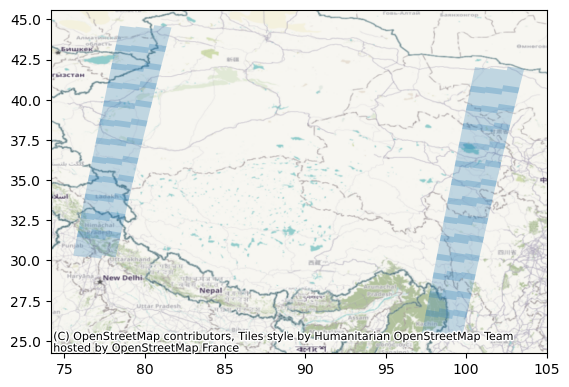

In [22]:
fig, ax = plt.subplots()
df_gunw_foot_sub.plot(ax=ax, alpha=.25)
cx.add_basemap(ax, crs=df_ifg_submission.crs.to_string())

In [23]:
df_ifg_submission.shape

(19444, 8)

# Deduplication of IFGs CMR - Requires CMR Ingest

We can use this as the reference for data has been processed. We will use the fixed frames. See this [PR](https://github.com/asfadmin/Discovery-asf_search/issues/198) for more details about how this feature is access through ASF Search.

The raw CMR command for a comparable query is:
```
https://cmr.uat.earthdata.nasa.gov/search/granules.umm_json?short_name=SENTINEL-1_INTERFEROGRAMS&temporal=2022-02-24T00:00:00Z,2022-02-25T00:00:00Z&attribute[]=int,FRAME_NUMBER,25502&attribute[]=int,TEMPORAL_BASELINE_DAYS,12
```

Make sure not to use more than 5 threads at a time as that will overload CMR server that handles such requests.

In [24]:
def get_gunw_hits(record):

    frame_id = int(record['frame_id'])
    ref_date = parse(record['reference_date'])
    sec_date = parse(record['secondary_date'])
    
    start = ref_date - timedelta(days=.5)
    end = ref_date + timedelta(days=.5)
    tb_days = (ref_date - sec_date).days
    

    opts = asf.ASFSearchOptions(host='cmr.uat.earthdata.nasa.gov', 
                                platform=asf.SENTINEL1,
                                processingLevel=asf.constants.GUNW_STD,
                                frame=frame_id, 
                                start=start, 
                                end=end, 
                                temporalBaselineDays=[tb_days],
                                maxResults=5
                                )
    
    results = asf.search(opts=opts)
    return len(results)

In [26]:
submission_records = df_ifg_submission.to_dict('records')
#get_gunw_hits(submission_records[0])

In [27]:
n = len(submission_records)
ifg_hits_cmr = 0
# with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
#     ifg_hits_cmr = list(tqdm(executor.map(get_gunw_hits, submission_records[:100]), total=n))

In [30]:
# # TODO: set to ifg_hits_cmr
# print('Before dedup: ', df_ifg_submission.shape[0])
# df_ifg_submission['cmr_hits'] = ifg_hits_cmr
# if ifg_hits_cmr:
#     df_ifg_submission = df_ifg_submission[df_ifg_submission['ifg_hits_cmr'] == 0].reset_index(drop=True)
# print('After dedup: ', df_ifg_submission.shape[0])

# Format Job Parameters

We format the dictionary of inputs for the interferograms (IFGs) into the format required by Hyp3 (just reformats into another dictionary).

In [31]:
submission_records[0]

{'reference': 'S1A_IW_SLC__1SDV_20221025T231816_20221025T231846_045605_0573F5_C579 S1A_IW_SLC__1SDV_20221025T231844_20221025T231912_045605_0573F5_71C8',
 'secondary': 'S1A_IW_SLC__1SDV_20221013T231816_20221013T231846_045430_056EC3_953D S1A_IW_SLC__1SDV_20221013T231844_20221013T231912_045430_056EC3_93EA',
 'reference_date': '2022-10-25',
 'secondary_date': '2022-10-13',
 'frame_id': 5033,
 'track_aoi_key': 'track33',
 'aoi_name': 'tibet',
 'geometry': <POLYGON Z ((100.257 40.668 0, 100.497 41.807 0, 103.577 41.807 0, 103.562 4...>}

In [37]:
def generate_job_name(record):
    track_key = record['track_aoi_key']
    aoi_name = record['aoi_name']
    return f'{aoi_name}-{track_key}'

In [38]:
job_names = list(map(generate_job_name, submission_records))
job_names_unique = sorted(list(set(job_names)))
job_names_unique[:5]

['tibet-track136', 'tibet-track33']

In [40]:
WEATHER_MODEL = None

In [41]:
job_parameters = [{'granules': record['reference'].split(' '),
                   'secondary_granules': record['secondary'].split(' '),
                   'frame_id': int(record['frame_id']),
                   'weather_model': WEATHER_MODEL,
                  } for record in submission_records]

job_dicts = [{'name': job_name,
              # NOTE: we are still using the `dev` branch. Change this to "INSAR_ISCE" to use the `main` branch.
              'job_type': 'INSAR_ISCE',
              'job_parameters': parameters
             }
             for parameters, job_name in zip(job_parameters, job_names) ]
job_dicts[:2]

[{'name': 'tibet-track33',
  'job_type': 'INSAR_ISCE',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20221025T231816_20221025T231846_045605_0573F5_C579',
    'S1A_IW_SLC__1SDV_20221025T231844_20221025T231912_045605_0573F5_71C8'],
   'secondary_granules': ['S1A_IW_SLC__1SDV_20221013T231816_20221013T231846_045430_056EC3_953D',
    'S1A_IW_SLC__1SDV_20221013T231844_20221013T231912_045430_056EC3_93EA'],
   'frame_id': 5033,
   'weather_model': None}},
 {'name': 'tibet-track33',
  'job_type': 'INSAR_ISCE',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20221025T231844_20221025T231912_045605_0573F5_71C8',
    'S1A_IW_SLC__1SDV_20221025T231910_20221025T231937_045605_0573F5_DD04'],
   'secondary_granules': ['S1A_IW_SLC__1SDV_20221013T231844_20221013T231912_045430_056EC3_93EA',
    'S1A_IW_SLC__1SDV_20221013T231910_20221013T231936_045430_056EC3_0D86'],
   'frame_id': 5034,
   'weather_model': None}}]

# Submit Jobs to Hyp3

This is where we take the job dictionaries and submit them to Hyp3. Note, we have different AWS accounts associated to different API endpoints i.e. `hyp3-a19-jpl` and `hyp3-tibet-jpl` are different AWS accounts using the same workflow and are separated for accounting purposes.

In [ ]:
# uses .netrc; add `prompt=True` to prompt for credentials; 
#hyp3_isce = hyp3_sdk.HyP3('https://hyp3-a19-jpl.asf.alaska.edu')
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-tibet-jpl.asf.alaska.edu', prompt=True)

Grouping jobs by name

In [85]:
jobs_by_group = list(map(lambda job_name: [j for j in job_dicts
                                           if j['name'] == job_name], tqdm(job_names_unique)))

100%|███████████████████████████████| 15/15 [00:00<00:00, 221.25it/s]


Hyp3 requires us to submit 200 jobs at a time.

In [86]:
def divide_into_batches(job_dict_l: list[dict]) -> list[list]:
    N_batches = int(np.ceil(len(job_dict_l) / 200))
    job_dicts_batches = [job_dict_l[200 * k : 200 * (k + 1)] for k in range(N_batches)]
    return job_dicts_batches

submission_by_group_batches = list(map(divide_into_batches, jobs_by_group))
len(submission_by_group_batches), len(submission_by_group_batches[0])

(15, 3)

Below these are what should be uncommented to actually submit the jobs.

In [87]:
## For testing - only submit 1 batch
# submitted_jobs = list(hyp3_isce.submit_prepared_jobs(submission_by_group_batches[0][0][:]))

In [88]:
# submitted_jobs = []
# for batches_for_job_name in submission_by_group_batches[:]:
#     job_name = batches_for_job_name[0][0]['name']
#     ub = 200 * len(batches_for_job_name)
#     lb = ub - 200
#     input(prompt=f'Please hit enter when ready to process {job_name}; There are between {lb} and {ub} jobs')
#     for batch_of_job_dicts in tqdm(batches_for_job_name, desc='batches'):
#         submitted_jobs += list(hyp3_isce.submit_prepared_jobs(batch_of_job_dicts))

Please hit enter when ready to process track113-n3; There are between 400 and 600 jobs


batches: 100%|█████████████████████████| 3/3 [00:18<00:00,  6.11s/it]


Please hit enter when ready to process track121-n3; There are between 10000 and 10200 jobs


batches: 100%|███████████████████████| 51/51 [03:22<00:00,  3.96s/it]


Please hit enter when ready to process track128-n3; There are between 0 and 200 jobs


batches: 100%|█████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


Please hit enter when ready to process track135-n3; There are between 3800 and 4000 jobs


batches: 100%|███████████████████████| 20/20 [01:50<00:00,  5.55s/it]


Please hit enter when ready to process track150-n3; There are between 7400 and 7600 jobs


batches: 100%|███████████████████████| 38/38 [02:53<00:00,  4.56s/it]


Please hit enter when ready to process track164-n3; There are between 3600 and 3800 jobs


batches: 100%|███████████████████████| 19/19 [01:07<00:00,  3.57s/it]


Please hit enter when ready to process track19-n3; There are between 1400 and 1600 jobs


batches: 100%|█████████████████████████| 8/8 [00:48<00:00,  6.00s/it]


Please hit enter when ready to process track26-n3; There are between 0 and 200 jobs


batches: 100%|█████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


Please hit enter when ready to process track33-n3; There are between 7600 and 7800 jobs


batches: 100%|███████████████████████| 39/39 [02:47<00:00,  4.30s/it]


Please hit enter when ready to process track4-n3; There are between 12000 and 12200 jobs


batches: 100%|███████████████████████| 61/61 [04:30<00:00,  4.43s/it]


Please hit enter when ready to process track48-n3; There are between 15600 and 15800 jobs


batches: 100%|███████████████████████| 79/79 [05:27<00:00,  4.14s/it]


Please hit enter when ready to process track62-n3; There are between 7400 and 7600 jobs


batches: 100%|█| 38/38 [03:18<00:00,  5.22s/it


Please hit enter when ready to process track77-n3; There are between 11800 and 12000 jobs


batches: 100%|█| 60/60 [05:53<00:00,  5.89s/it


Please hit enter when ready to process track84-n3; There are between 0 and 200 jobs


batches: 100%|██| 1/1 [00:07<00:00,  7.74s/it]


Please hit enter when ready to process track91-n3; There are between 2800 and 3000 jobs


batches: 100%|█| 15/15 [00:56<00:00,  3.75s/it


# Check the status

Check status; note that we use the `start` keyword argument. This massively optimizes search queries (you can use this information in the dynamoDB query).

In [42]:
JOB_NAMES_INSPECTION = job_names_unique[:5] # ['track48-n3']
JOB_NAMES_INSPECTION

['track106-n3']

In [91]:
now = datetime.datetime.now()
submit_time_approx = datetime.datetime(2023, 8, 25)##now - timedelta(hours=24)

In [92]:
for job_name in JOB_NAMES_INSPECTION:
    jobs = hyp3_isce.find_jobs(name=job_name, start=submit_time_approx)
    print('#' * 10)
    print(job_name)
    print(jobs)

##########
track106-n3
9102 HyP3 Jobs: 6659 succeeded, 2443 failed, 0 running, 0 pending.


# Failed jobs

Looked at failed jobs. Again, this will be cleaned up once we ingest into CMR.

In [54]:
now = datetime.datetime.now()
submit_time_approx = now - timedelta(hours=15)

In [55]:
JOB_NAME_INSPECTION = job_names_unique[0]

In [57]:
failed_jobs = hyp3_isce.find_jobs(name=JOB_NAME_INSPECTION, status_code='FAILED', start=submit_time_approx)
dicts_failed = [j.to_dict() for j in failed_jobs]
dicts_failed[-10:]

[{'job_id': 'a72f7873-5011-42ae-af28-300dc44cbee5',
  'job_type': 'INSAR_ISCE_TEST',
  'request_time': '2023-08-25T03:36:55+00:00',
  'status_code': 'FAILED',
  'user_id': 'access_cloud_based_insar',
  'name': 'track106-n3',
  'job_parameters': {'compute_solid_earth_tide': True,
   'estimate_ionosphere_delay': True,
   'frame_id': 16420,
   'granules': ['S1A_IW_SLC__1SDV_20230615T225929_20230615T225956_049003_05E492_C8D9',
    'S1A_IW_SLC__1SDV_20230615T225954_20230615T230021_049003_05E492_3D08'],
   'secondary_granules': ['S1A_IW_SLC__1SDV_20230522T225928_20230522T225955_048653_05DA0B_720C',
    'S1A_IW_SLC__1SDV_20230522T225953_20230522T230020_048653_05DA0B_80AB'],
   'weather_model': 'HRRR'},
  'logs': ['https://hyp3-tibet-jpl-contentbucket-81rn23hp7ppf.s3.us-west-2.amazonaws.com/a72f7873-5011-42ae-af28-300dc44cbee5/a72f7873-5011-42ae-af28-300dc44cbee5.log'],
  'expiration_time': '2023-10-25T00:00:00+00:00',
  'processing_times': [8633.635]},
 {'job_id': '804dd1ef-9c7f-4635-8056-8d3